# Predicting Customer Churn Risk and Future Purchases

It’s more cost effective to retain existing customers than to acquire new ones, which is why it’s important to track customers at high risk of turnover (churn) and target them with retention strategies.

The primary goal of this work is to build a probabilistic model for forecasting **customer lifetime value(Future Purchases)** and **customer churn risk** in non-contractual setting on an individual level.


The probabilistic model that I’ll use is the BG/NBD model from the Lifetimes package.

1. Distinguish active customers from inactive customers.
2. Generate transaction forecasts for individual customers.
3. Predict the purchase volume of the entire customer base.
4. Predict customer churn risk


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive
import matplotlib as mpl
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus=False)

orders = pd.read_csv('data/olist_orders_dataset.csv')
items = pd.read_csv('data/olist_order_items_dataset.csv')
cust = pd.read_csv('data/olist_customers_dataset.csv')




### Data Cleaning

The lifetimes package relies on recency-frequency-monetary (RFM) analysis to model churn and customer lifetime value (CLV). To make our models, we’ll need a a dataframe that consists of `recency`, `frequency`, and `monetary` columns. 

- `Recency`: time between initial purchase and most recent (last) purchase
- `Frequency`: number of repeat purchases made by a customer (total purchases — 1)
- `Monetary`: total spent on purchases

In [2]:
print(cust.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')


In [3]:
cust.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

The majority of customers made only a single purchase.

In [4]:
orders = pd.merge(orders,cust[['customer_id','customer_unique_id']],on='customer_id')
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id'],
      dtype='object')

In [5]:
print(items.columns)

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')


In [6]:
items.drop_duplicates('order_id',keep='first',inplace=True)

In [7]:
transaction_data = pd.merge(orders,items,'inner','order_id')
transaction_data = transaction_data[['customer_unique_id','order_purchase_timestamp','price']]
# convert timestamp to date
transaction_data['date'] = pd.to_datetime(transaction_data['order_purchase_timestamp']).dt.date
transaction_data = transaction_data.drop('order_purchase_timestamp',axis=1)
transaction_data.head()

,customer_unique_id,price,date
0,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10-02
1,af07308b275d755c9edb36a90c618231,118.70,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,159.90,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,45.00,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,19.90,2018-02-13


I want to convert this into dataframe with the RFM variables that I mentioned in the introduction. The Lifetimes package has a function for converting transaction data into an RFM DataFrame.

In [8]:
summary = summary_data_from_transaction_data(transaction_data,'customer_unique_id','date',monetary_value_col='price',)
summary.describe()


,frequency,recency,T,monetary_value
count,95420.000000,95420.000000,95420.000000,95420.000000
mean,0.024198,2.683389,246.184846,2.474897
std,0.178936,25.263074,153.656402,26.579606
min,0.000000,0.000000,5.000000,0.000000
25%,0.000000,0.000000,122.000000,0.000000
50%,0.000000,0.000000,227.000000,0.000000
75%,0.000000,0.000000,356.000000,0.000000
max,15.000000,633.000000,729.000000,1999.990000


In [9]:
summary.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,116.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,119.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,542.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,326.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,293.0,0.0


 Many of the customers have frequency, recency, and monetary = 0. That's because Lifetimes only considers customers who have made repeat purchases into account.
 
- `frequency`: # of days in which a customer made a repeat purchase
- `T`: customer's age in days
- `recency`: customer's age in days at time of most recent purchase
- `monetary_value`: mean of a customer's purchases, excluding the 1st purchase

In [10]:
summary[summary['frequency']>0].head(10)

,frequency,recency,T,monetary_value
customer_unique_id,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,403.0,87.90
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,367.0,27.00
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,196.0,72.58
00a39521eb40f7012db50455bf083460,1.0,11.0,103.0,11.55
011575986092c30523ecb71ff10cb473,1.0,60.0,198.0,63.90
011b4adcd54683b480c4d841250a987f,1.0,177.0,377.0,56.97
012452d40dafae4df401bced74cdb490,1.0,330.0,442.0,330.00
012a218df8995d3ec3bb221828360c86,1.0,42.0,119.0,1369.90
013ef03e0f3f408dd9bf555e4edcdc0a,1.0,29.0,74.0,59.90


In [11]:
transaction_data[transaction_data['customer_unique_id']=='004288347e5e88a27ded2bb23747066c']


,customer_unique_id,price,date
33396,004288347e5e88a27ded2bb23747066c,229.99,2017-07-27
39730,004288347e5e88a27ded2bb23747066c,87.90,2018-01-14


### Visualizing the RFM DataFrame


Assumptions of the BG/NBD model:  
- A customer’s relationship has two phases: “alive” for an unobserved period of time, then “dead”
- While alive, the number of transactions made by a customer follows a Poisson distribution with transaction rate lambda
- Heterogeneity in lambda follows a gamma distribution
- After any transaction, a customer dies with probability p; the probability that a customer dies after a number of transactions follows a geometric distribution
- p follows a beta distribution
- Lambda and p vary independently across customers

In [12]:
bgf = BetaGeoFitter(penalizer_coef=0.00)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 95420 subjects, a: 2.07, alpha: 65.86, b: 0.35, r: 0.02>

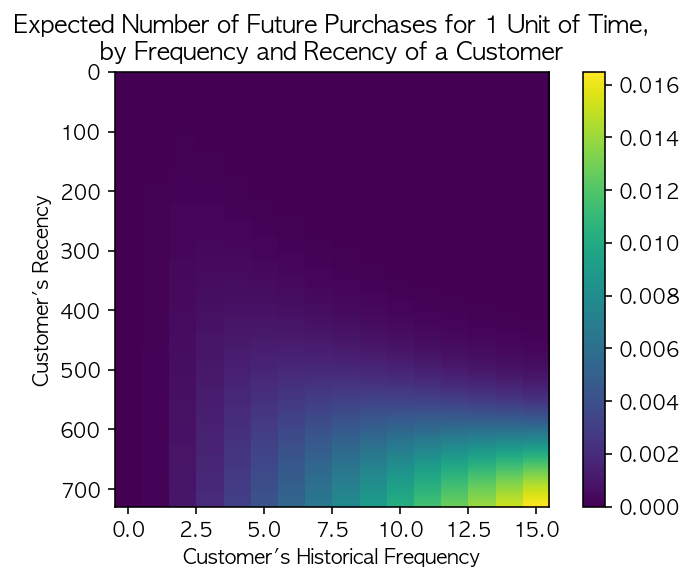

In [13]:
plot_frequency_recency_matrix(bgf)

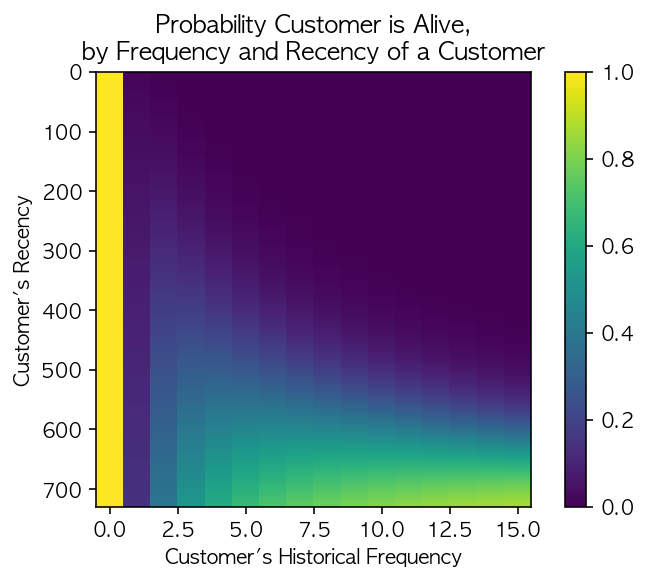

In [14]:
plot_probability_alive_matrix(bgf)

## Modeling Future Purchases(Life Time Value)

1) **Calibration period histogram**: does the model fit the training data?  
2) **Cumulative transaction plot**: does the model predict cumulative sales well?  
3) **Incremental transaction plot**: does the model capture the overall trend in transactions?  
4) **Conditional expectations plot**: can the model predict the number of purchases a customer will make based on the training data?  

### 1) Calibration period histogram

/Users/jahoy/anaconda3/lib/python3.6/site-packages/lifetimes/generate_data.py:54: RuntimeWarning: overflow encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)
/Users/jahoy/anaconda3/lib/python3.6/site-packages/lifetimes/generate_data.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)


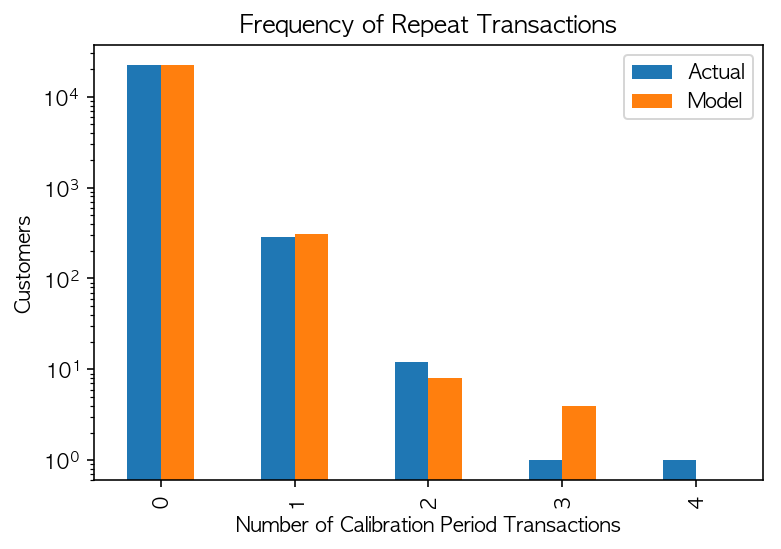

In [26]:
plot_period_transactions(bgf).set_yscale('log')

We can see that our actual data and our simulated data line up well. The model is fairly representative of the real data up until five repeat transactions. There are few customers who make more purchases.

### 2) Cumulative transaction plot

In [16]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'customer_unique_id', 'date',calibration_period_end='2017-09-03', observation_period_end='2018-09-03' )



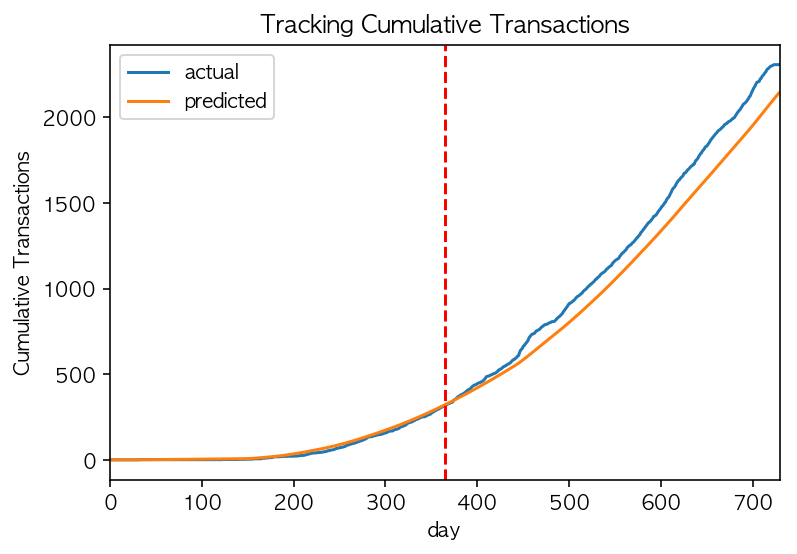

In [17]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf, transaction_data, 'date', 'customer_unique_id', 730, 365)


The red line represents the boundary between the calibration period on the left and the holdout period on the right. As you can see, the BG/NBD model is good at predicting cumulative transactions.

### 3) Incremental transaction plot

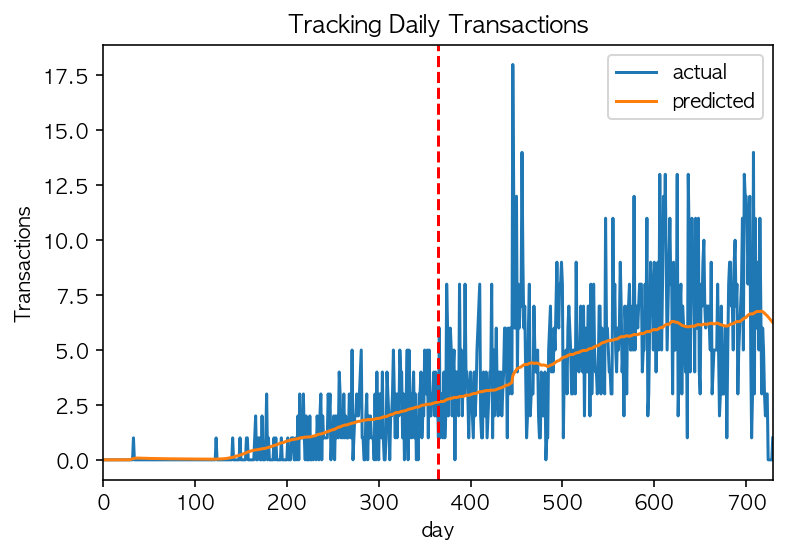

In [18]:
plot_incremental_transactions(bgf, transaction_data, 'date', 'customer_unique_id', 730, 365);


This plot shows that the model does a decent job capturing general trends in the data.

### 4) Conditional expectations plot

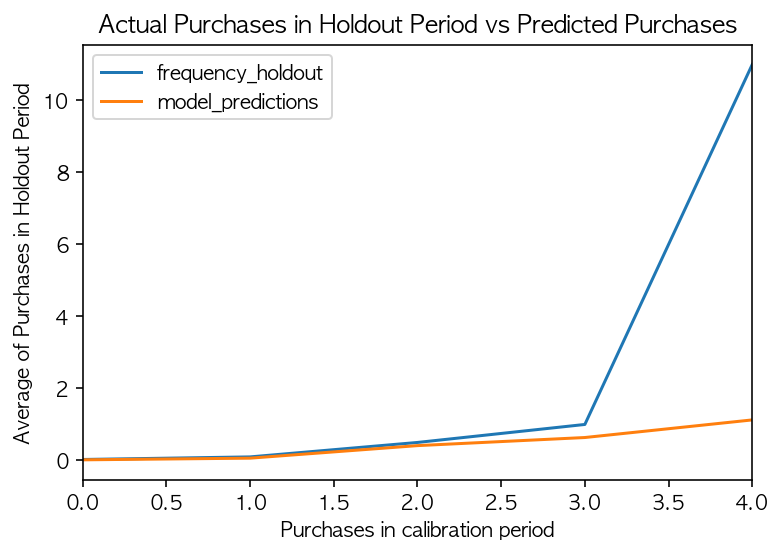

In [19]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)


The model performs well up to three calibration period purchases, but diverges from the holdout data because of the distribution of the data.

In [20]:
cust.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

Less than 1% of customers have made four or more purchases, so there’s not much data for the BG/NBD model to learn about customers who have made many repeat transactions.

## Modeling Churn Risk

we’ll only predict churn risk on customers who have made at least one repeat transaction.

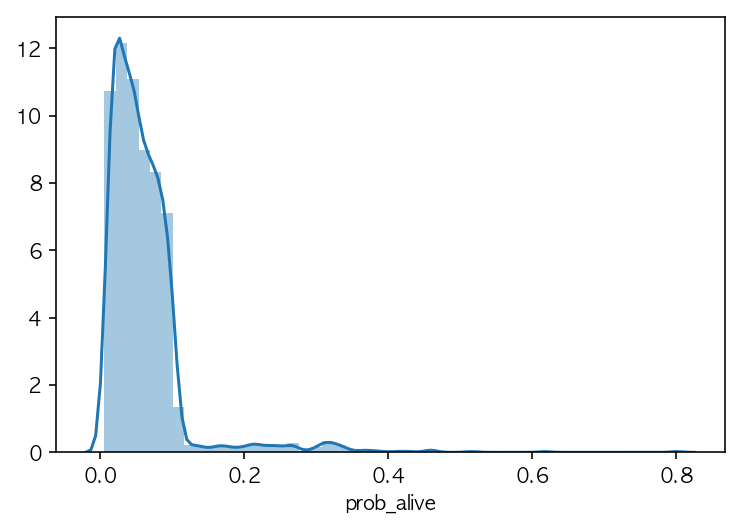

In [21]:
df = summary[summary['frequency']>0]
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'],df['recency'],df['T'])
sns.distplot(df['prob_alive'])



Using domain knowledge we might be able to set a threshold for customers who probably have already churned, and also identify customers who are at risk for churning, but haven’t yet disappeared.

Assume a customer with <10% chance of being alive to have churned.


In [22]:
df.head()

,frequency,recency,T,monetary_value,prob_alive
customer_unique_id,,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,403.0,87.90,0.053200
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,367.0,27.00,0.082272
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,196.0,72.58,0.033793
00a39521eb40f7012db50455bf083460,1.0,11.0,103.0,11.55,0.039748
011575986092c30523ecb71ff10cb473,1.0,60.0,198.0,63.90,0.046973


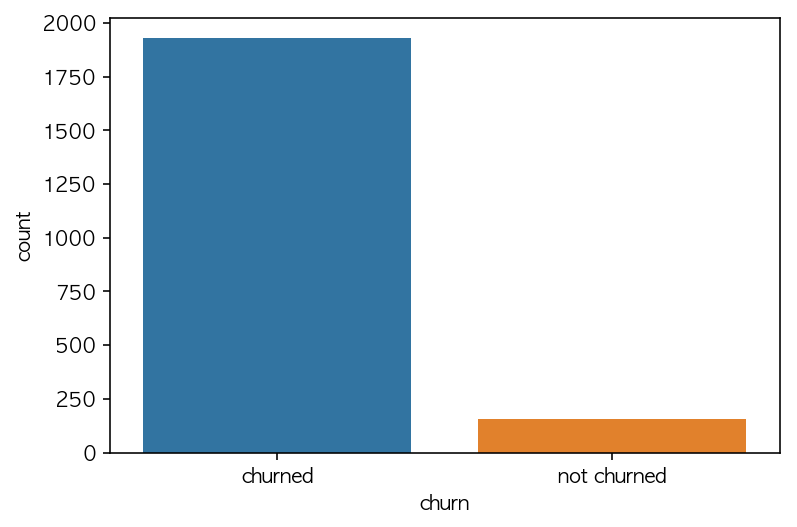

In [23]:
df['churn'] = ['churned' if p < 0.1 else 'not churned' for p in df['prob_alive']]
sns.countplot(df['churn'])

A little over 92% of customers have churned, meaning that there’s a lot of opportunity for improvement regarding retention.
We can assume that the customers who have churned are already lost.   

Let's find the customers who are at high risk for churn, but haven’t churned yet. Later on, it might still be a good idea to apply different treatments to the churned group.

Text(0.5, 1.0, 'Probability alive, not churned')

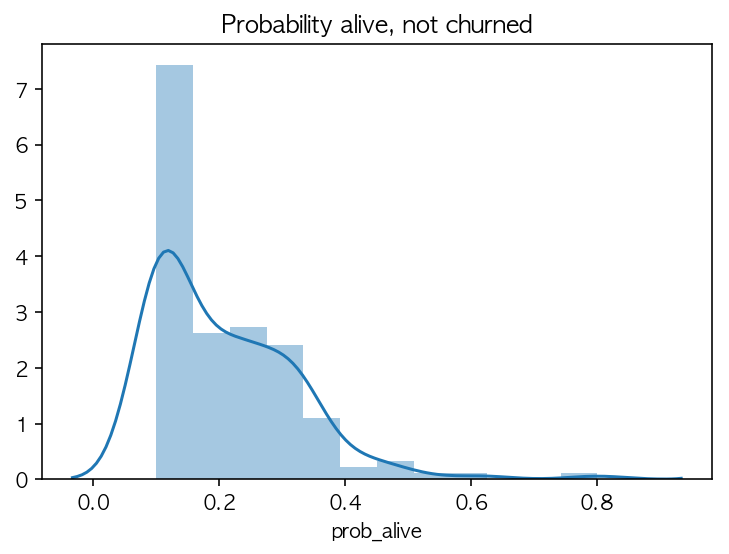

In [24]:
sns.distplot(df[df['churn']=='not churned']['prob_alive']).set_title('Probability alive, not churned')


It seems reasonable to bucket customers with 80% or more churn risk to be considered high risk for churn.


In [25]:
df['churn'][(df['prob_alive']>=0.1) & (df['prob_alive']<0.2)] = "high risk"
df['churn'].value_counts()



churned        1928
high risk        84
not churned      73
Name: churn, dtype: int64

Now that I have these churn groupings, I can move forward and apply special treatments to these groups. 

- `churned`:        1928
- `high risk`:        84
- `not churned`:      73

## Conclusion

**1) Reach out to churned customers to figure out why they left.**   
**2) Send different types of targeted emails and special offers to the high risk group.**  
**3) Determine the the highest value customers in the non-churn group, and serve them additional benefits to ensure that they remain loyal customers(VIP).**
